In [368]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import glob
import itertools
import skimage.color
import skimage.segmentation
import skimage.graph
import skimage.future
import skimage.exposure
%matplotlib inline

# PLANS

In [2]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])
def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']

# Original colors

[[[ 99 255 176]
  [  9 206 208]
  [120  32  16]
  [ 48 157 153]
  [ 22 255 247]]]


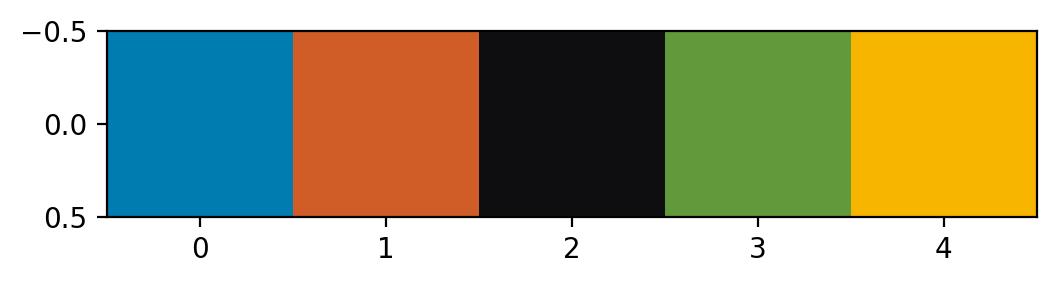

In [3]:
orig_colors_img = np.array([COLORS])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(orig_colors_img)
print(cv2.cvtColor(orig_colors_img, cv2.COLOR_RGB2HSV))

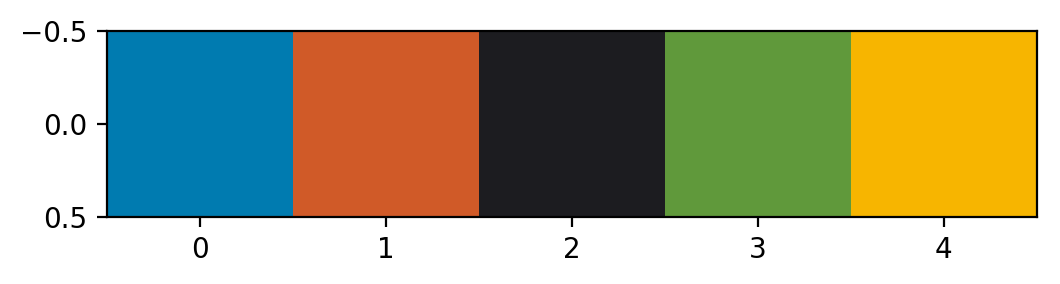

In [303]:
orig_colors_img = np.array([COLORS])
orig_colors_img = cv2.cvtColor(orig_colors_img, cv2.COLOR_RGB2HSV)
orig_colors_img[:, :, 2] = np.where(orig_colors_img[:, :, 2] < 125, 2 * orig_colors_img[:, :, 2], orig_colors_img[:, :, 2])
orig_colors_img = cv2.cvtColor(orig_colors_img, cv2.COLOR_HSV2RGB)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(orig_colors_img)

# Show image

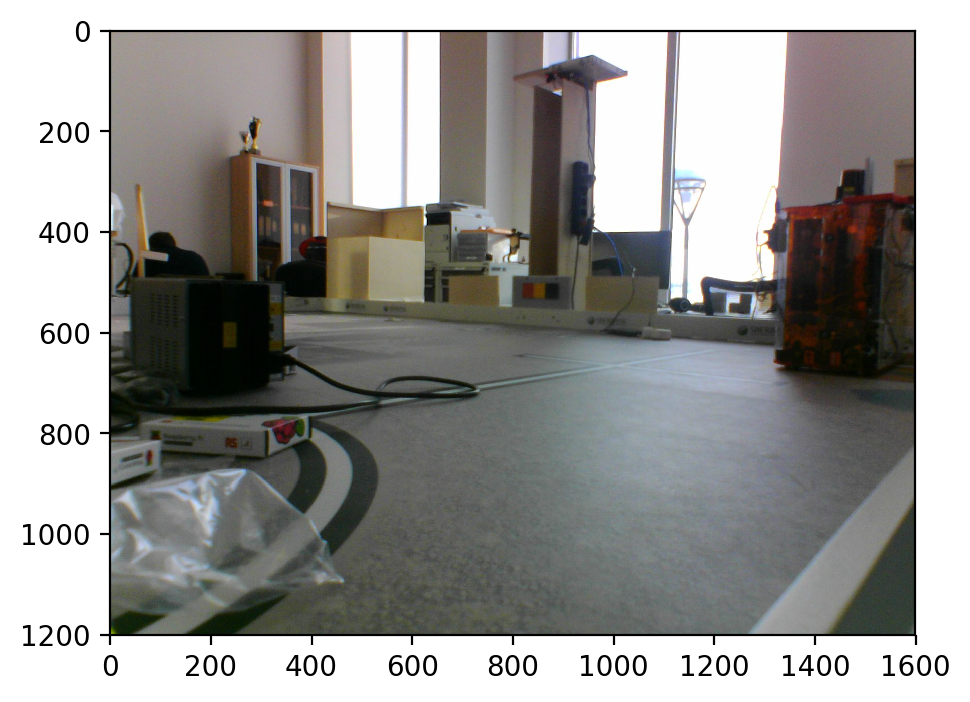

In [443]:
img = cv2.cvtColor(cv2.imread("imgs/142.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(img);

# Projection transformation using specific matrix

In [444]:
step = 4

In [445]:
img_points = np.float32([(798, 549), (798, 488), (912, 487), (912, 553)])
h_border = 3 * step * 2
w_border = 7 * step * 2
h_rect = int(130 / 30 * step)
w_rect = int(300 / 30 * step)
dw = (w_border - w_rect) / 2
dh = (h_border - h_rect) / 2
real_points = np.float32([(dw, h_border - dh), (dw, dh), 
                          (w_border - dw, dh), (w_border - dw, h_border - dh)])
M = cv2.getPerspectiveTransform(img_points, real_points)

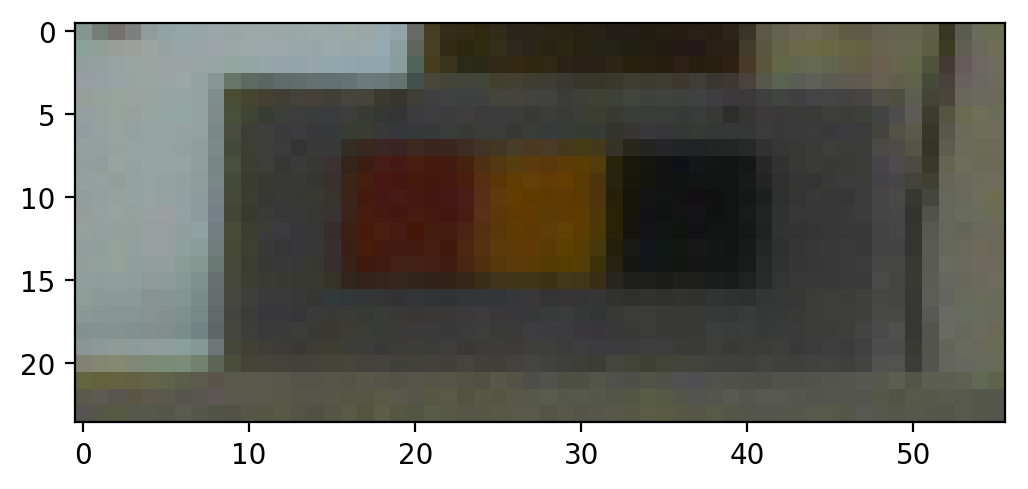

In [446]:
small_img = cv2.warpPerspective(img, M, (w_border, h_border))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(small_img);

# Image equalization

## Histogram

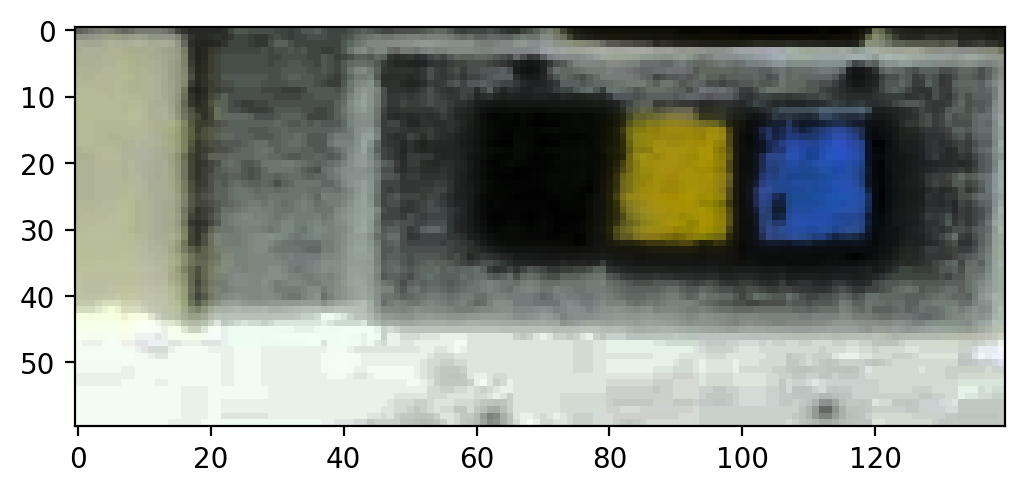

In [98]:
# hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2YCrCb)
hist_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
hist_img[:, :, 2] = cv2.equalizeHist(hist_img[:, :, 2])
hist_img = cv2.cvtColor(hist_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(hist_img);

## Clahe + median

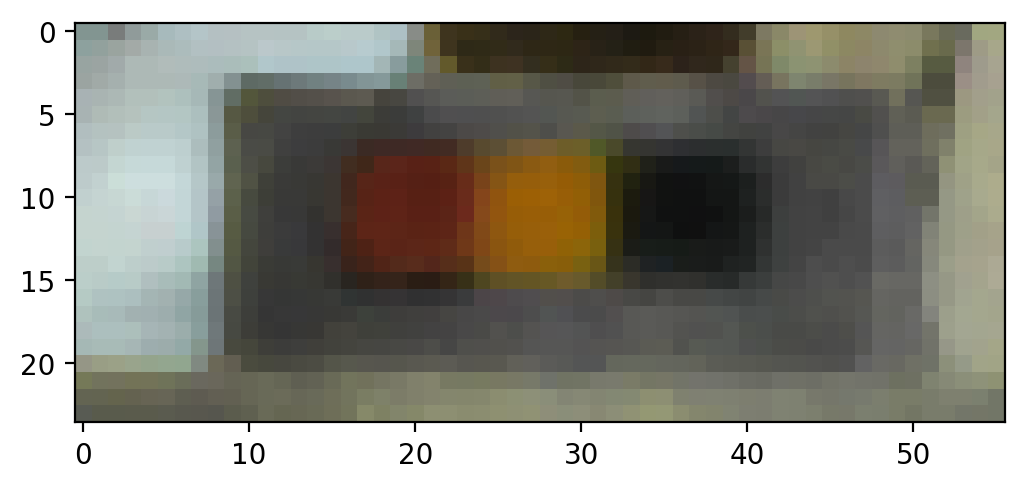

In [447]:
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step - 1 + step % 2)
clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img);

## Clh + max_S

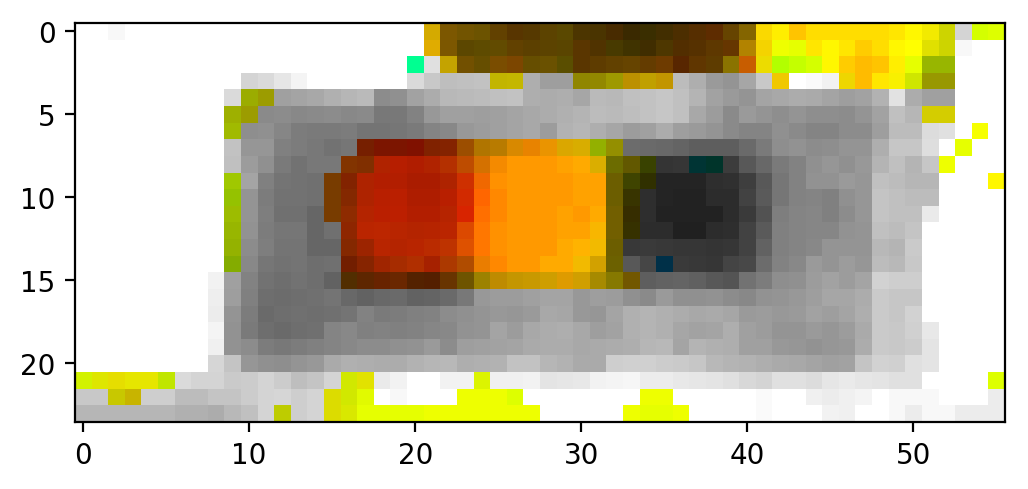

In [464]:
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step - 1 + step % 2)

clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

img2 = cv2.cvtColor(clh_img, cv2.COLOR_RGB2HSV)
img2[:, :, 1] = np.where(img2[:, :, 1] > np.mean(img2[:, :, 1]), 255, 0)
img2[:, :, 2] = np.where(img2[:, :, 2] > 125, 255, 2 * img2[:, :, 2])
img2 = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
clh_contr_img = img2
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(img2, cmap="gray");

## Laplacian + CLh + median

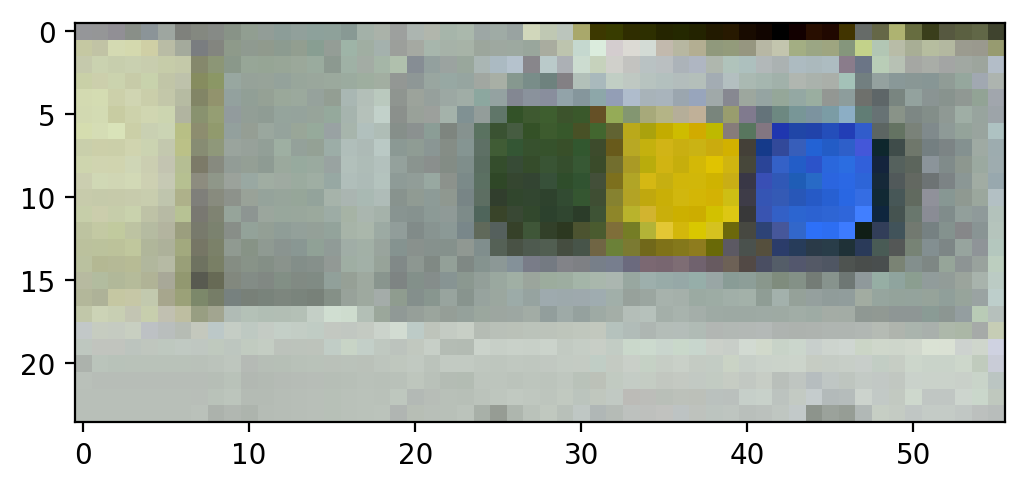

In [412]:
#img_1 = cv2.GaussianBlur(small_img,(13,13),10)
vl = int(step)
img_1 = cv2.medianBlur(small_img, vl - 1 + vl % 2)

clh_img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img_1[:, :, 2] = clahe.apply(clh_img_1[:, :, 2])
clh_img_1 = cv2.cvtColor(clh_img_1, cv2.COLOR_HSV2RGB)

# img2 = cv2.cvtColor(clh_img_1, cv2.COLOR_RGB2HSV)
# img2[:, :, 1] = np.where(img2[:, :, 1] > np.mean(img2[:, :, 1]), 255, 0)
# img2[:, :, 2] = np.where(img2[:, :, 2] > 125, 255, 2 * img2[:, :, 2])
# img_1 = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)

img_1 = clh_img_1
c = -0.40
img_1 = c * cv2.Laplacian(img_1 / 255, cv2.CV_64F) + img_1 / 255
img_1 = (255 * img_1.clip(0, 1)).astype(np.uint8)
clh_img_1 = img_1

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img_1);

# RAG

Wall time: 82.2 ms


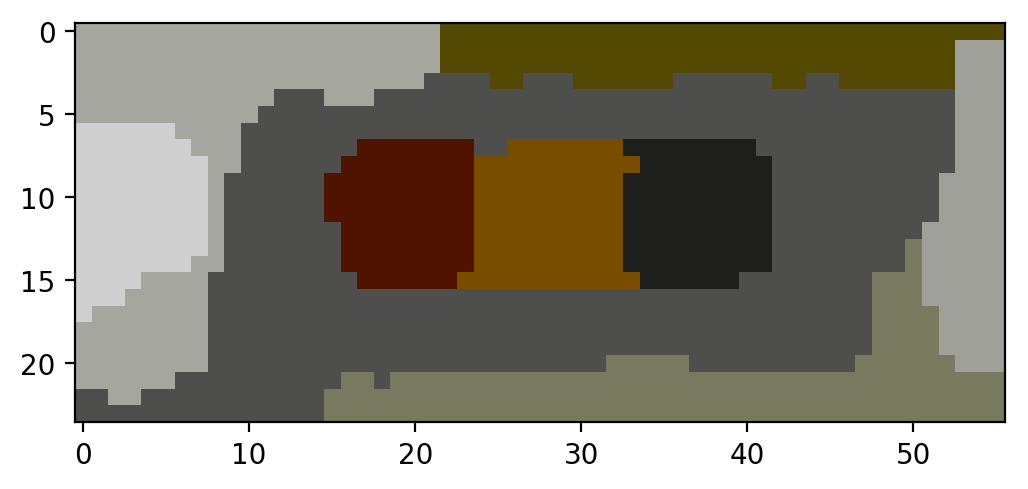

In [449]:
%%time
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])


input_img = clh_contr_img
labels = skimage.segmentation.slic(input_img, compactness=10, n_segments=20)
g = skimage.future.graph.rag_mean_color(input_img, labels)

labels2 = skimage.future.graph.merge_hierarchical(labels, g, thresh=50, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

rag_img = skimage.color.label2rgb(labels2, input_img, kind='avg')
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(rag_img);

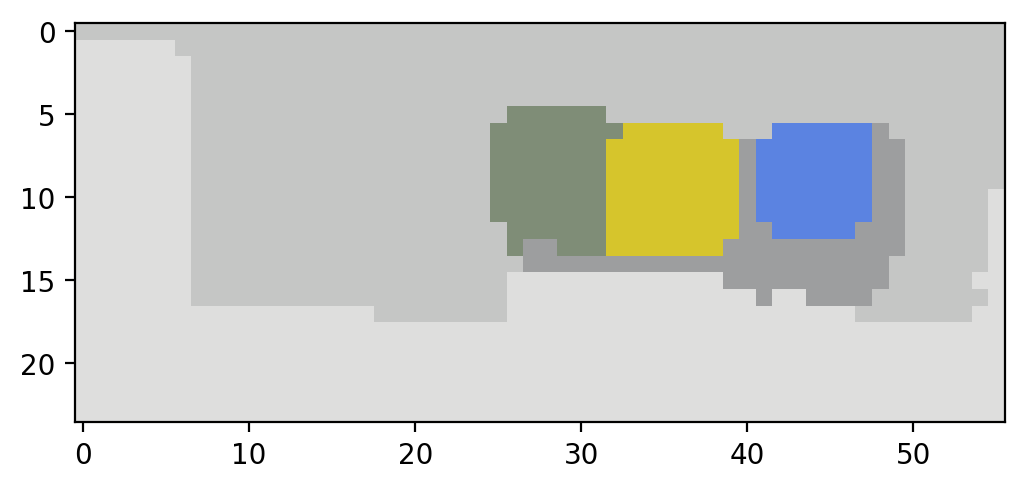

In [424]:
img2 = cv2.cvtColor(rag_img, cv2.COLOR_RGB2HSV)
img2[:, :, 1] = skimage.exposure.adjust_gamma(img2[:, :, 1], gamma=2, gain=1)
img2[:, :, 2] = skimage.exposure.adjust_gamma(img2[:, :, 2], gamma=0.5, gain=1)
rag_img_contr = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(rag_img_contr)

In [292]:
img2 = cv2.cvtColor(rag_img_contr, cv2.COLOR_RGB2HSV)
np.mean(img2[:, :, 2])

106.34821428571429

In [268]:
img2[10, 20]

array([ 63,  15, 154], dtype=uint8)

In [269]:
img2[10, 35]

array([ 26, 228, 178], dtype=uint8)

# Cube sequence searching

In [461]:
def get_distances_skimage(input_img):
    lab_COLORS = skimage.color.rgb2lab(COLORS[np.newaxis, :, :])[0]
    lab_img = skimage.color.rgb2lab(input_img)
    dist_array = skimage.color.deltaE_cmc(lab_img[:, :, np.newaxis], lab_COLORS[np.newaxis, np.newaxis, :],
                                          2, 1)
    return dist_array

## Dist array for full image

In [462]:
%%time
input_img = rag_img
full_dist_array = get_distances_skimage(input_img)
hight, width = input_img.shape[0] // step, input_img.shape[1] // step
dist_array = np.zeros((hight, width, COLORS.shape[0]))
for i in range(hight):
    for j in range(width):
        img_ = full_dist_array[step*i:step*i+step, step*j:step*j+step, :]
        dist_array[i, j, :] = np.mean(np.mean(img_,axis=0), axis=0)

Wall time: 0 ns


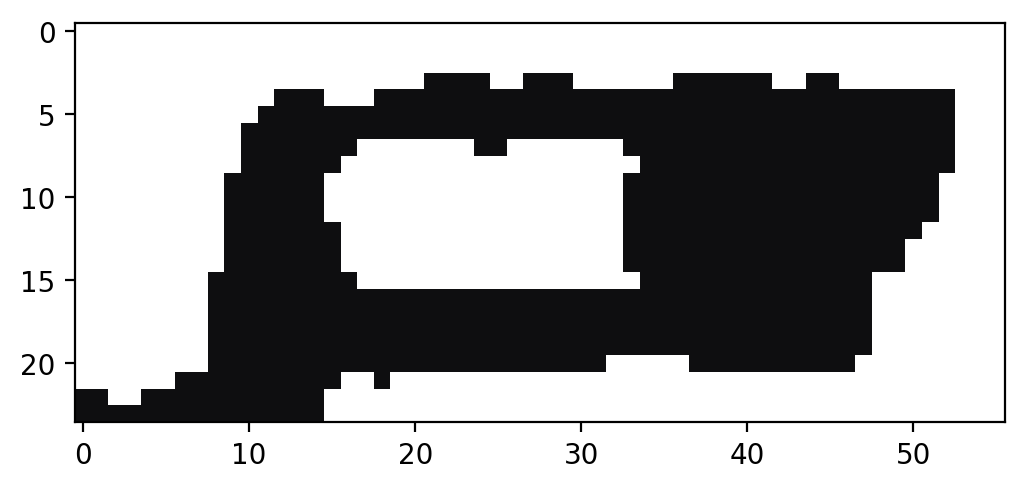

In [463]:
min_inds = np.argmin(full_dist_array, axis=2)
min_values = np.min(full_dist_array, axis=2)
min_min = np.mean(min_values)
out_img = COLORS[min_inds]
out_img[min_values > min_min] = [255, 255, 255]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(out_img);

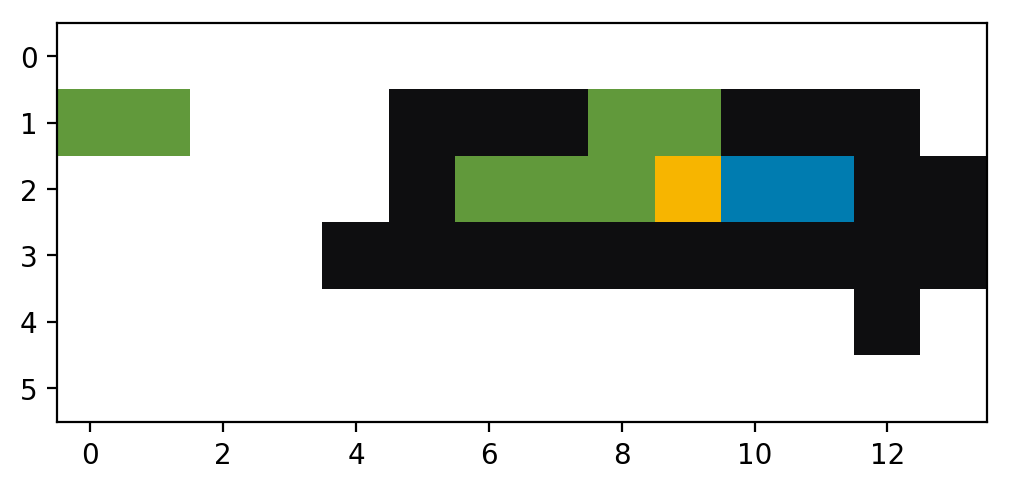

In [440]:
min_inds = np.argmin(dist_array, axis=2)
min_values = np.min(dist_array, axis=2)
min_min = np.mean(min_values)
avg_col_img = COLORS[min_inds]
avg_col_img[min_values > min_min] = [255, 255, 255]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(avg_col_img);

## Search plan

In [441]:
plan_dist_array = np.zeros((hight, width - 4, len(PLANS)))

for i, plan in enumerate(PLANS):
    plan_dist_array[:, :, i] = sum([np.roll(dist_array[:, :, plan[x]]**2, -2 * x, axis=1)[:, :-4] for x in range(3)])

best_plan = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[2]
ind = np.unravel_index(np.argmin(plan_dist_array), (hight, width - 4, len(PLANS)))[0:2]

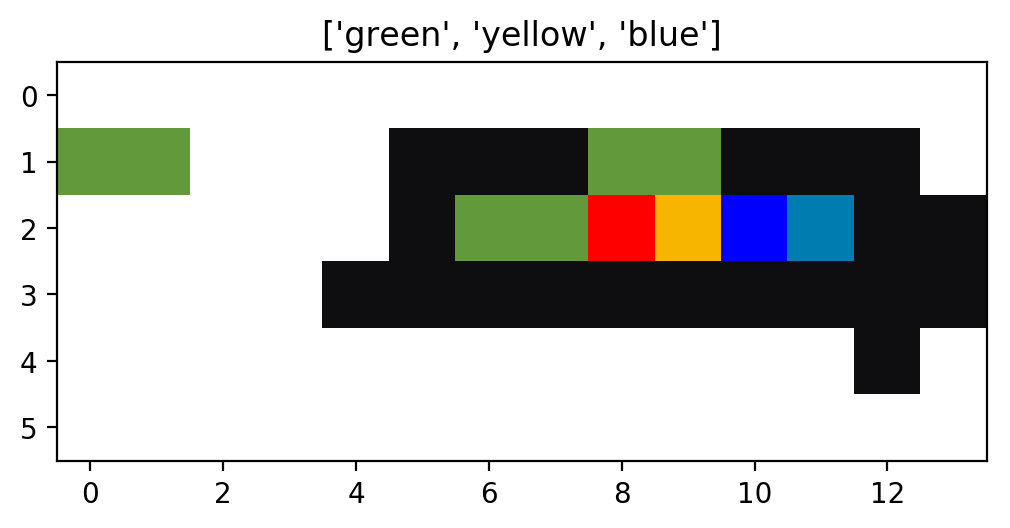

In [442]:
out_img = avg_col_img.copy()
out_img[ind[0], ind[1] + 1] = np.array([255, 0, 0])
out_img[ind[0], ind[1] + 3] = np.array([0, 0, 255])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.set_title([LABELS[PLANS[best_plan][x]] for x in range(3)])
ax.imshow(out_img);

# Projection transformation on images

In [16]:
files = glob.glob("imgs/*.png")
plans = [[LABELS[int(x_)] for x_ in x[5:8]] for x in files]

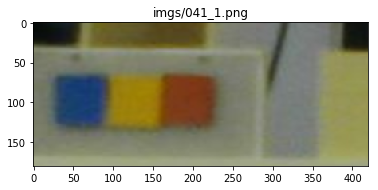

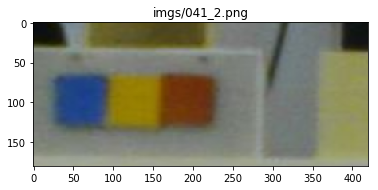

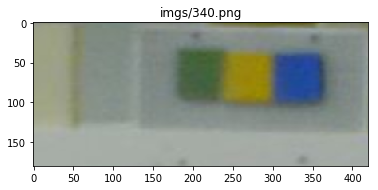

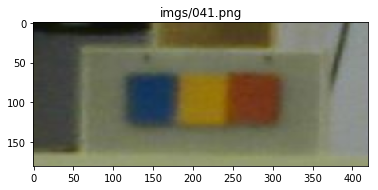

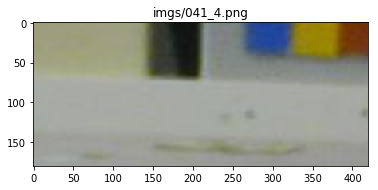

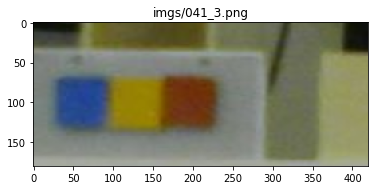

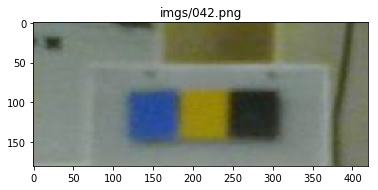

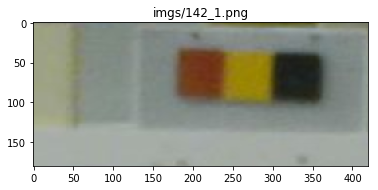

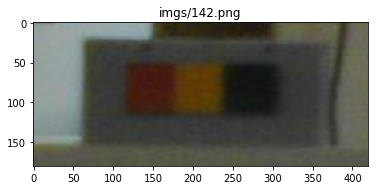

In [17]:
for file, plan in zip(files, plans):
    img_ = cv2.imread(file) 
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))

    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_RGB2BGR))
    plt.title(file)
    plt.show()   

# Test on many images

In [3]:
import sys
sys.path.insert(0, r"/home/mikhail/catkin_ws/src/ros-eurobot-2018/eurobot_camera/src/scripts/")
from PlanRecognition import find_colors, clh_transform, get_distances_skimage

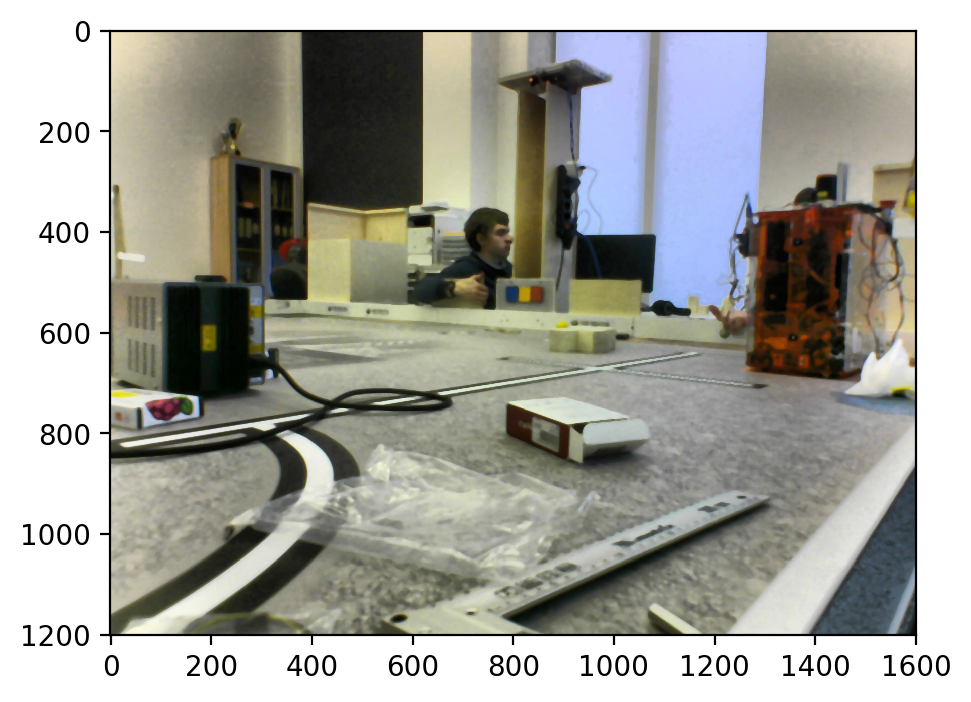

In [36]:
img_ = cv2.cvtColor(cv2.imread("imgs/041_1.png"), cv2.COLOR_BGR2RGB)
img_ = 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_transform(img_));

In [33]:
cv2.imread("imgs/041_1")

None


In [7]:
files = glob.glob("imgs/*.png")
plans = [[int(x_) for x_ in x[5:8]] for x in files]
n_files = len(files)
n_errors = 0
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))    
    found_plan = find_colors(img_)[0] 
    print(found_plan, plan, file)
    if found_plan != plan:
        print(False)
        n_errors += 1
print("Errors: %d from %d" % (n_errors, n_files))

[0, 4, 1] [0, 4, 1] imgs/041_1.png
[0, 4, 1] [0, 4, 1] imgs/041_2.png
[2, 4, 0] [3, 4, 0] imgs/340.png
False
[2, 4, 1] [0, 4, 1] imgs/041.png
False
[0, 4, 1] [0, 4, 1] imgs/041_4.png
[0, 4, 1] [0, 4, 1] imgs/041_3.png
[0, 4, 2] [0, 4, 2] imgs/042.png
[1, 4, 2] [1, 4, 2] imgs/142_1.png
[1, 4, 2] [1, 4, 2] imgs/142.png
Errors: 2 from 9


In [21]:
%%time
found_plan = find_colors(cv2.cvtColor(cv2.imread("imgs/432.png"), cv2.COLOR_BGR2RGB), M, h_border, w_border)[0]

error: /io/opencv/modules/imgproc/src/color.cpp:11079: error: (-215) scn == 3 || scn == 4 in function cvtColor


## Color metric

In [85]:
diff_colors = np.random.randint(0, 256, (200, 3), dtype=np.uint8)

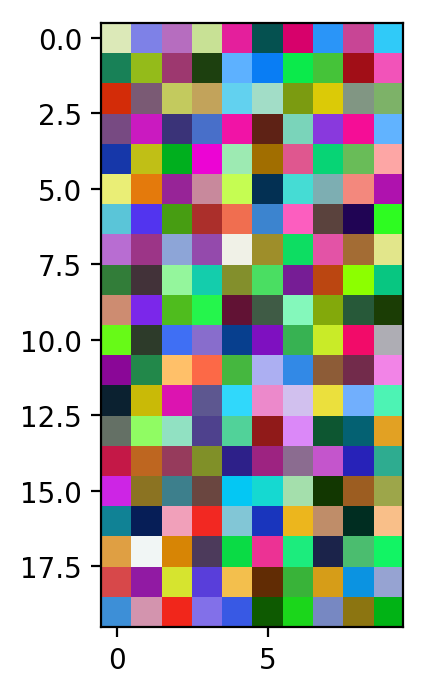

In [86]:
diff_colors_img = diff_colors.reshape(diff_colors.shape[0] // 10, 10, 3)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(diff_colors_img)

In [279]:
colors_dist_ecmc = np.zeros((diff_colors.shape[0], COLORS.shape[0]))
for i in range(COLORS.shape[0]):
    colors_dist_ecmc[:, i] =\
    np.apply_along_axis(color_distance, 1, diff_colors, COLORS[i])

In [280]:
def make_distance_img(colors_dist):
    to_colors = np.argmax(colors_dist, axis=1)
    diff_colors_1 = [(x_, y_, z_) for x_, y_, z_ in zip(diff_colors, 
                     np.argmin(colors_dist, axis=1), np.min(colors_dist, axis=1))]
    imgs = [None] * COLORS.shape[0]
    for i in range(COLORS.shape[0]):
        cols = [(x_[0], x_[2]) for x_ in diff_colors_1 if x_[1] == i]
        cols = sorted(cols, key = lambda x_: x_[1])
        cols = [x_[0] for x_ in cols]
        n = len(cols) + 1
        imgs[i] = np.array([COLORS[i]] + cols + ((10 - n % 10) % 10) * [[255, 255, 255]], 
                           dtype=np.uint8)
        imgs[i] = imgs[i].reshape(imgs[i].shape[0] // 10, 10, 3)
    return np.concatenate(imgs, axis=0)

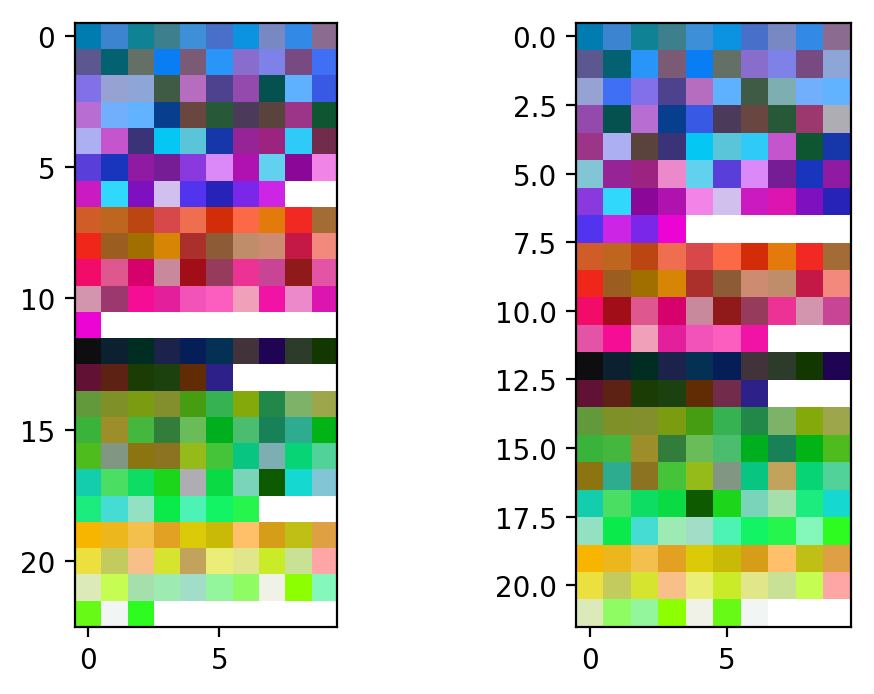

In [288]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(make_distance_img(colors_dist_lab2))
ax[1].imshow(make_distance_img(colors_dist_lab))